In [1]:
# !pip install transformers wandb
# !pip install gdown pandas scikit-learn evaluate emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
# !pip install --no-deps thai2transformers==0.1.2
# !pip install transformers[torch]
# !pip install jiwer

In [2]:
# import gdown

# url = "https://drive.google.com/file/d/19xt3kgVvSXcbXQdjsT3wqiz6a-UdAbht/view?usp=sharing"
# output = "nithan.zip"
# gdown.download(url=url, output=output, fuzzy=True)

# Prepare data

In [3]:
import pandas as pd

df = pd.read_csv('single_result/gt.txt', header=None, sep='\t')
df.columns = ['file_name', 'text']
df

,file_name,text
0,images/0/3.jpg,ของ
1,images/0/6.jpg,_
2,images/0/5.jpg,ได้
3,images/0/0.jpg,ฉัน
4,images/0/7.jpg,ของ
...,...,...
49995,images/4/49990.jpg,บัดนี้
49996,images/4/49997.jpg,_
49997,images/4/49996.jpg,เดินทาง
49998,images/4/49998.jpg,ก็


In [4]:
# from thai2transformers.preprocess import process_transformers
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased", model_max_length=416)

# def find_length(text):
#     text = process_transformers(text)
#     tokens = tokenizer(text)
#     return len(tokens['input_ids'])

# df['tokens_length'] = df['text'].apply(find_length)

# max_length = df['tokens_length'].max()
# min_length = df['tokens_length'].min()
# avg_length = df['tokens_length'].mean()
# length_95 = df['tokens_length'].quantile(0.95)
# length_99 = df['tokens_length'].quantile(0.99)

# print(f"Maximum tokens length: {max_length}")
# print(f"Minimum tokens length: {min_length}")
# print(f"Average tokens length: {avg_length}")
# print(f"95% of the texts have length less than or equal to: {length_95}")
# print(f"99% of the texts have length less than or equal to: {length_99}")

In [19]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from thai2transformers.preprocess import process_transformers

class MyDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=20):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        if text == '_':
            image = Image.open(self.root_dir + file_name).convert("RGB")
            size = image.size[0]
            image = image.resize((size*2, size))
        else:
            image = Image.open(self.root_dir + file_name).convert("RGB")

        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        text = process_transformers(text)
        labels = self.processor.tokenizer(text, 
                                          padding="max_length",
                                          truncation=True,
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
    
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [20]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor, TrOCRProcessor

# image_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten').image_processor
# tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased", model_max_length=416)
# processor = TrOCRProcessor(image_processor=image_processor, tokenizer=tokenizer)
processor = TrOCRProcessor.from_pretrained('kkatiz/thai-trocr-thaigov-v2')

train_dataset = MyDataset(root_dir='single_result/',
                           df=train_df,
                           processor=processor)
eval_dataset = MyDataset(root_dir='single_result/',
                           df=test_df,
                           processor=processor)

In [21]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 40000
Number of validation examples: 10000


In [9]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([20])


In [10]:
# from tqdm.auto import tqdm

# for i in tqdm(range(len(train_dataset))):
#     encoding = train_dataset[i]
#     if len(encoding['labels']) != train_dataset.max_target_length:
#         print(f"Label at index {i} has length {len(encoding['labels'])}, which is not equal to max_target_length.")
#         break
#     if encoding['pixel_values'].size(0) != 3:
#         print(f"Label at index {i} has pixel_values {encoding['pixel_values'].shape}")
#         break

#     labels = encoding['labels']
#     labels[labels == -100] = processor.tokenizer.pad_token_id
#     label_str = processor.decode(labels, skip_special_tokens=True)
#     if label_str == "":
#         print(f"Label string at index {i} is empty.")
#         break
# else: 
#     print("No errors found.")

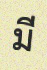

In [11]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [12]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

มี


# Train a model

In [22]:
from transformers import VisionEncoderDecoderModel, GenerationConfig, CamembertForCausalLM, VisionEncoderDecoderConfig

# encoder = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten').encoder
# encoder.save_pretrained('encoder')

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("encoder", "airesearch/wangchanberta-base-att-spm-uncased")
# model.config
# model = VisionEncoderDecoderModel.from_pretrained('kkatiz/thai-trocr-thaigov-v2')
model = VisionEncoderDecoderModel.from_pretrained('nithan-ocr/checkpoint-500/')

In [23]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# # set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
# model.config.max_length = 64
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 4

model.generation_config = GenerationConfig(
    decoder_start_token_id = processor.tokenizer.cls_token_id,
    pad_token_id = processor.tokenizer.pad_token_id,
    vocab_size = model.config.decoder.vocab_size,
    max_length = 64,
    eos_token_id = processor.tokenizer.sep_token_id,
    early_stopping = True,
    no_repeat_ngram_size = 3,
    length_penalty = 2.0,
    num_beams = 4
)

In [24]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import wandb

model_name = 'nithan-ocr'

wandb.init(project="thai-ocr", name=model_name, resume=True)

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, 
    output_dir=model_name,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_steps=2,
    save_steps=500,
    eval_steps=500,
    warmup_steps=843, # ((len(dataset) / batch_size) * n_epochs) * want_protion e.g 0.1
    num_train_epochs = 3,
    overwrite_output_dir=True,
    save_total_limit=3,
    report_to='wandb',
    run_name=model_name,
    resume_from_checkpoint=True
)

wandb: WARNING Ensure read and write access to run files dir: /home/wandb/run-20240308_232845-u1054yoa/files, control this via the WANDB_DIR env var. See https://docs.wandb.ai/guides/track/environment-variables


eval/cer,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,▆█▆▄▅▆▅▅▆▅▅▄▄▄▄▄▄▃▂▂▃▂▄▅▄▄▂▂▂▃▃▃▄▃▃▁▃▄▂▃
eval/cer,0.10547


In [25]:
import evaluate

cer_metric = evaluate.load("cer")

In [26]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [27]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train(resume_from_checkpoint=True)
# trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
There were missing keys in the checkpoint model loaded: ['decoder.lm_head.decoder.weight', 'decoder.lm_head.decoder.bias'].
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Cer
1000,0.172000,0.164313,0.065633
1500,0.061600,0.119879,0.044115
2000,0.053300,0.090604,0.033867
2500,0.036900,0.070106,0.027196
3000,0.005600,0.063369,0.022938
3500,0.037600,0.058463,0.020354


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=3750, training_loss=0.08984003741629422, metrics={'train_runtime': 6280.8699, 'train_samples_per_second': 19.106, 'train_steps_per_second': 0.597, 'total_flos': 6.392185002786816e+19, 'train_loss': 0.08984003741629422, 'epoch': 3.0})

In [28]:
trainer.evaluate()

{'eval_loss': 0.05729099363088608,
 'eval_cer': 0.019161982626469086,
 'eval_runtime': 385.8082,
 'eval_samples_per_second': 25.92,
 'eval_steps_per_second': 0.811,
 'epoch': 3.0}

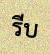

รีบ


In [44]:
image = Image.open('single_result/images/0/139.jpg').convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values.to('cuda')
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

display(image)
print(generated_text)

In [30]:
# model.save_pretrained('best_model')
# processor.save_pretrained('best_model')

[]

In [31]:
# test_model = VisionEncoderDecoderModel.from_pretrained('best_model')
# test_processor = TrOCRProcessor.from_pretrained('best_model')

In [33]:
# model.push_to_hub("ocr-nithan", private=True)
# processor.push_to_hub('ocr-nithan', private=True)

model.safetensors:   0%|          | 0.00/881M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kkatiz/ocr-nithan/commit/b55c31aebf69b5acb51eb92b1381a2dc83cf7df2', commit_message='Upload processor', commit_description='', oid='b55c31aebf69b5acb51eb92b1381a2dc83cf7df2', pr_url=None, pr_revision=None, pr_num=None)